In [132]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
import cv2
from math import *
from scipy.ndimage.interpolation import rotate
import math
from scipy.stats import linregress
from scipy.interpolate import splrep, sproot, splev

class MultiplePeaks(Exception): pass
class NoPeaksFound(Exception): pass


In [133]:
def fwhm(x, y, k=3):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    half_max = np.max(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)

    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return abs(roots[1] - roots[0])

In [134]:
def eclipse_fit(array):
    Array_hun_scale=np.round(np.array(array)*100)

    # # threshold

    thresh = cv2.threshold(Array_hun_scale.astype(np.uint8),1 , 255, cv2.THRESH_BINARY)[1]

    # find largest contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    # print(contours)
    big_contour = max(contours, key=cv2.contourArea)

    # fit contour to ellipse and get ellipse center, minor and major diameters and angle in degree 
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(d1,d2),angle = ellipse
    #     print(xc,yc,d1,d1,angle)

    # draw ellipse
    result = Array_hun_scale.copy()
    cv2.ellipse(result, ellipse, (0, 255, 0), 3)

    # draw circle at center
    xc, yc = ellipse[0]
    cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)

    # draw vertical line
    # compute major radius
    rmajor = max(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90
    return angle

In [3]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt 

In [136]:
#wo_lens
wo_lens = io.imread('15-8-2022\\time-loading-10s\\image_MOT-15-8-TOF-1s.tif').astype(np.int8)
np.shape(wo_lens)

(2, 1080, 1440)

150 150


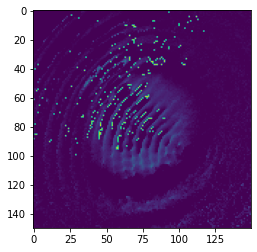

In [137]:
yt,yb,xl,xr=290,440,620,770
widthy=yb-yt
widthx=xr-xl
print(widthx,widthy)

A = wo_lens[1]
B = wo_lens[0]
C = np.zeros(A.shape)
C[A != 0] =1-(B[A != 0]/A[A != 0])
C[C<0]=0

wo_lens_crop=C[yt:yb,xl:xr]
plt.imshow(wo_lens_crop)


138.2593231201172


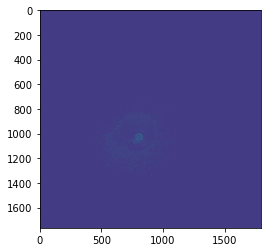

In [138]:
angle = eclipse_fit(wo_lens_crop)
print(angle)

wo_lens_rot = rotate(C,angle)
plt.imshow(wo_lens_rot)

300 300


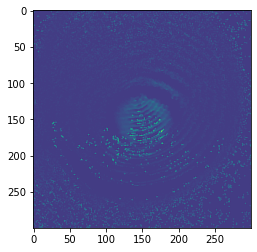

In [139]:
yt,yb,xl,xr=875,1175,650,950
widthy=yb-yt
widthx=xr-xl
print(widthx,widthy)
wo_lens_rot_crop = wo_lens_rot[yt:yb,xl:xr]
plt.imshow(wo_lens_rot_crop)

In [140]:
sum_y=[]
for i in range(300):
    yv=np.sum(wo_lens_rot_crop[i,100:200])
    sum_y.append(yv)

sum_x=[]
for i in range(300):
    xv=np.sum(wo_lens_rot_crop[100:200,i])
    sum_x.append(xv)

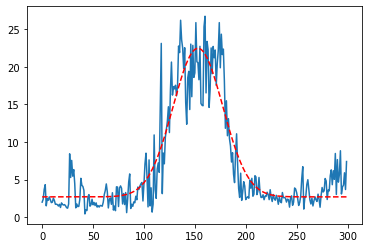

In [141]:
x=np.arange(300)
plt.plot(sum_x)
plt.plot(x, gauss(x, *gauss_fit(x, sum_x)),'--r',color='red')

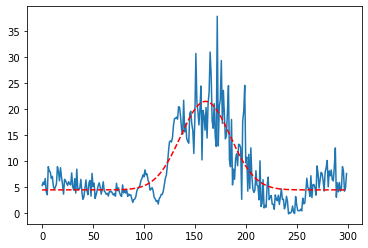

In [142]:
plt.plot(sum_y)
plt.plot(x, gauss(x, *gauss_fit(x, sum_y)),'--r',color='red')

In [166]:
fwhm_wo_lens_x = fwhm(x,gauss(x, *gauss_fit(x, sum_x)))
fwhm_wo_lens_y = fwhm(x,gauss(x, *gauss_fit(x, sum_y)))
print(fwhm_wo_lens_x,fwhm_wo_lens_y)

63.501349399590495 68.72952972276916


In [144]:
#w_lens
w_lens = io.imread('Mot_18-08\\1ms.tif').astype(np.int8)
np.shape(w_lens)

(30, 1080, 1440)

150 150


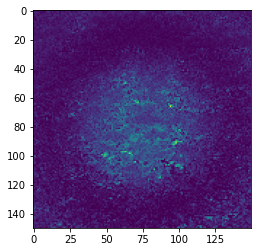

In [145]:
yt,yb,xl,xr=515,665,475,625
widthy=yb-yt
widthx=xr-xl
print(widthx,widthy)

array_value=np.zeros([1080,1440])
for i in range(int(w_lens.shape[0]/2)):
    A = w_lens[(2*i)+1]
    B = w_lens[(2*i)]
    C = np.zeros(A.shape)
    C[A != 0] =1-(B[A != 0]/A[A != 0])
    C[C<0]=0
    array_value+=C
w_lens_ave=array_value/int(w_lens.shape[0]/2)
w_lens_crop = w_lens_ave[yt:yb,xl:xr]
array_value=np.zeros([1080,1440])

plt.imshow(w_lens_crop)

172.0475082397461


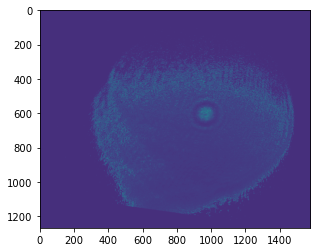

In [146]:
angle_w = eclipse_fit(w_lens_crop)
print(angle_w)

w_lens_rot = rotate(w_lens_ave,angle_w)
plt.imshow(w_lens_rot)

300 300


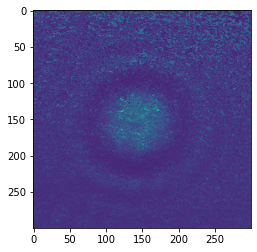

In [147]:
yt,yb,xl,xr=450,750,820,1120
widthy=yb-yt
widthx=xr-xl
print(widthx,widthy)
w_lens_rot_crop = w_lens_rot[yt:yb,xl:xr]
plt.imshow(w_lens_rot_crop)

In [148]:
sum_y_w=[]
for i in range(300):
    yvw=np.sum(w_lens_rot_crop[i,100:200])
    sum_y_w.append(yvw)

sum_x_w=[]
for i in range(300):
    xvw=np.sum(w_lens_rot_crop[100:200,i])
    sum_x_w.append(xvw)

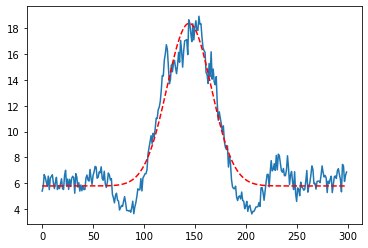

In [149]:
plt.plot(sum_x_w)
plt.plot(x, gauss(x, *gauss_fit(x, sum_x_w)),'--r',color='red')

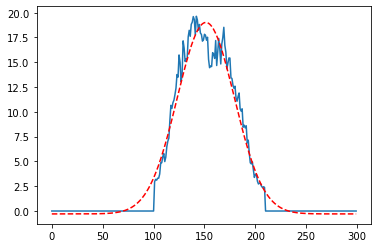

In [167]:

sum_y_w[:100] = np.zeros(100)
sum_y_w[210:] = np.zeros(90)

plt.plot(sum_y_w)
sum_y_w = gauss(x, *gauss_fit(x, sum_y_w))

plt.plot(x,gauss_fit_sum_yw ,'--r',color='red')

In [168]:
fwhm_w_lens_x = fwhm(x,gauss(x, *gauss_fit(x, sum_x_w)))
fwhm_w_lens_y = fwhm(x,gauss(x, *gauss_fit(x, sum_y_w)))
print(fwhm_w_lens_x,fwhm_w_lens_y)

70.39174643982312 65.37256586271042


In [ ]:
63.501349399590495 70.39174643982312

In [ ]:
x              0.000585

In [1]:
(63.501349399590495*0.000585)/70.39174643982312

0.0005277364361249081